# Visão Computacional - Lista de Exercícios 3
Alunos:
- Luana Júlia Nunes Ferreira
- Lucas Mendes Massa

# Questão 1

In [2]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

In [3]:
def describe(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    (kps,features) = sift.detectAndCompute(image,None)
    kps = np.float32([kp.pt for kp in kps])
    return (kps,features)

In [4]:
def match(kA,kB,fA,fB,ratio,thresh):
    matcher = cv2.DescriptorMatcher_create('BruteForce')
    raw = matcher.knnMatch(fA,fB,2)
    matches = []
    for m in raw:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    
    if len(matches) > 4:
        ptsA = np.float32([kA[i] for (_, i) in matches])
        ptsB = np.float32([kB[i] for (i, _) in matches])
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, thresh)
        return (matches, H, status)

    return None

In [5]:
def twoImagesPanorama(images,ratio=0.75,thresh=4):
    (imA,imB) = images
    (kA,fA) = describe(imA)
    (kB,fB) = describe(imB)
    M = match(kA, kB, fA, fB, ratio, thresh)
    if M is None:
        return None
        
    (matches, H, status) = M

    h1,w1 = imB.shape[:2]
    h2,w2 = imA.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    
    result = cv2.warpPerspective(imA, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = imB
    return result

In [6]:
imageA = cv2.imread('./p1.png')
imageB = cv2.imread('./p2_.png')
imageA = imutils.resize(imageA, width=400,height=220)
imageB = imutils.resize(imageB, width=400,height=220)
imageA = cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB)
imageB = cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB)

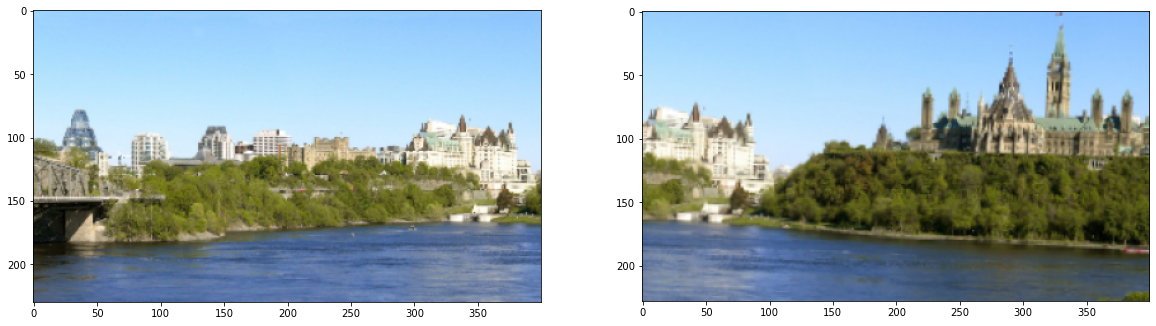

In [7]:
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(imageA)
axarr[1].imshow(imageB)

In [8]:
result = twoImagesPanorama((imageA,imageB))

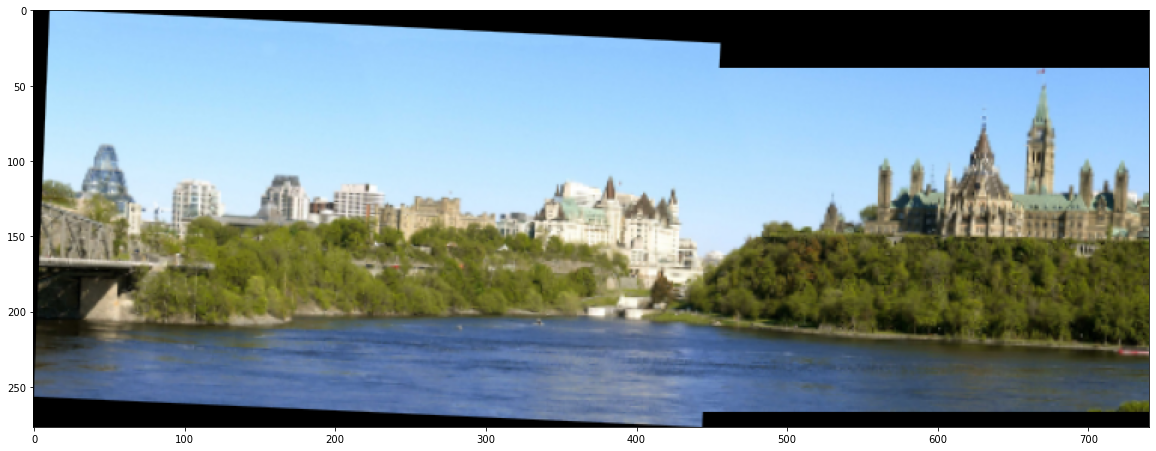

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(result)

# Questão 2

In [10]:
imageC = cv2.imread('./p3.png')
imageC = imutils.resize(imageC, width=400,height=220)
imageC = cv2.cvtColor(imageC,cv2.COLOR_BGR2RGB)

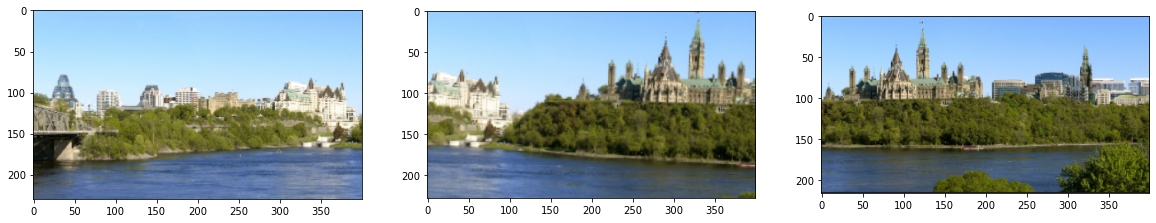

In [11]:
f, axarr = plt.subplots(1,3, figsize=(20,20))
axarr[0].imshow(imageA)
axarr[1].imshow(imageB)
axarr[2].imshow(imageC)

### Plano da primeira imagem

In [12]:
def firstImagePlanePanorama(images,ratio=0.75,thresh=4):
    (imA,imB,imC) = images
    (kA,fA) = describe(imA)
    (kB,fB) = describe(imB)
    (kC,fC) = describe(imC)
    M1 = match(kA, kA, fA, fA, ratio, thresh)
    M2 = match(kC, kB, fC, fB, ratio, thresh)
    M3 = match(kB, kA, fB, fA, ratio, thresh)
    
    if (M1 is None) or (M2 is None) or (M3 is None):
        return None
    
    (matches, H, status) = M1
    (matches2, H2, status2) = M2

    (matches3, H3, status3) = M3
    
    h1,w1 = imC.shape[:2]
    h2,w2 = imB.shape[:2]
    h3,w3 = imA.shape[:2]
    
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts3 = np.float32([[0,0],[0,h3],[w3,h3],[w3,0]]).reshape(-1,1,2)
    
    pts1_ = cv2.perspectiveTransform(pts1, H2) # composição de homografias
    pts1_ = cv2.perspectiveTransform(pts1, H3)
    
    pts2_ = cv2.perspectiveTransform(pts2, H3)
    
    pts3_ = cv2.perspectiveTransform(pts3, H)
    
    pts = np.concatenate((pts3_, pts2_, pts1_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    
    result1 = cv2.warpPerspective(imA, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result2 = cv2.warpPerspective(imB, Ht.dot(H3), (xmax-xmin, ymax-ymin))
    result3 = cv2.warpPerspective(imC, Ht.dot(H3.dot(H2)), (xmax-xmin, ymax-ymin))
    result_ = cv2.bitwise_or(result1,result2)
    result = cv2.bitwise_or(result_, result3)
    return result

In [13]:
first = firstImagePlanePanorama((imageA,imageB,imageC))

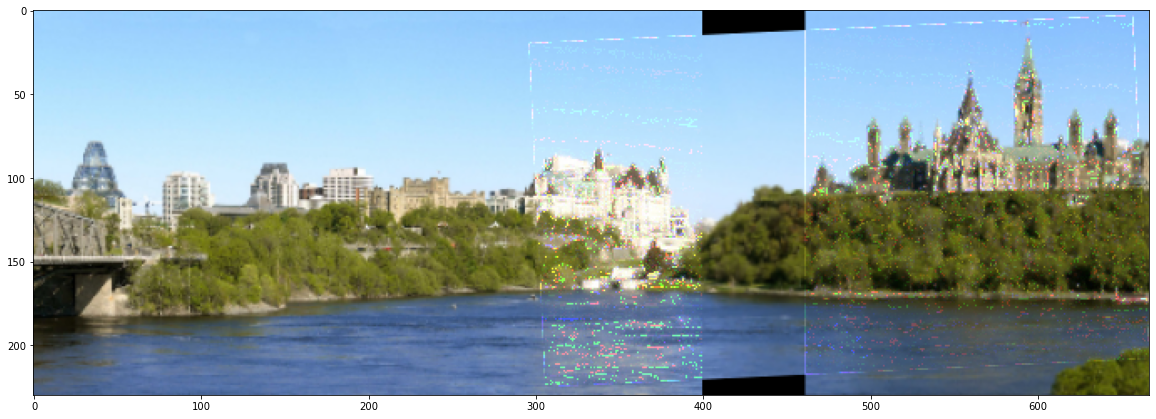

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(first)

### Plano da segunda imagem

In [15]:
def secondImagePlanePanorama(images,ratio=0.75,thresh=4):
    (imA,imB,imC) = images
    (kA,fA) = describe(imA)
    (kB,fB) = describe(imB)
    (kC,fC) = describe(imC)
    M1 = match(kA, kB, fA, fB, ratio, thresh)
    M2 = match(kC, kB, fC, fB, ratio, thresh)
    M3 = match(kB, kB, fB, fB, ratio, thresh)
    
    if (M1 is None) or (M2 is None) or (M3 is None):
        return None
    
    (matches, H, status) = M2
    (matches2, H2, status2) = M1

    (matches3, H3, status3) = M3
    
    h1,w1 = imC.shape[:2]
    h2,w2 = imB.shape[:2]
    h3,w3 = imA.shape[:2]
    
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts3 = np.float32([[0,0],[0,h3],[w3,h3],[w3,0]]).reshape(-1,1,2)
    
    pts1_ = cv2.perspectiveTransform(pts1, H)
    
    pts2_ = cv2.perspectiveTransform(pts2, H3)
    
    pts3_ = cv2.perspectiveTransform(pts3, H2)
    
    pts = np.concatenate((pts3_, pts2_, pts1_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    
    result1 = cv2.warpPerspective(imA, Ht.dot(H2), (xmax-xmin, ymax-ymin))
    result2 = cv2.warpPerspective(imB, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result3 = cv2.warpPerspective(imC, Ht.dot(H3), (xmax-xmin, ymax-ymin))
    result_ = cv2.bitwise_or(result1,result2)
    result = cv2.bitwise_or(result_, result3)
    return result

In [16]:
second = secondImagePlanePanorama((imageA,imageB,imageC))

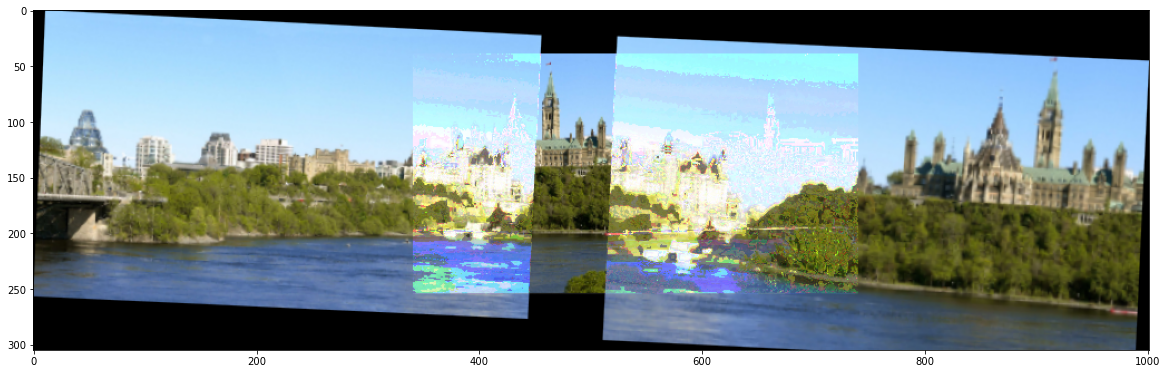

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(second)

### Plano da terceira imagem

In [18]:
def thirdImagePlanePanorama(images,ratio=0.75,thresh=4):
    (imA,imB,imC) = images
    (kA,fA) = describe(imA)
    (kB,fB) = describe(imB)
    (kC,fC) = describe(imC)
    M1 = match(kA, kB, fA, fB, ratio, thresh)
    M2 = match(kB, kC, fB, fC, ratio, thresh)
    M3 = match(kC, kC, fC, fC, ratio, thresh)
    
    if (M1 is None) or (M2 is None) or (M3 is None):
        return None
    
    (matches, H, status) = M2
    (matches2, H2, status2) = M1

    (matches3, H3, status3) = M3
    
    h1,w1 = imC.shape[:2]
    h2,w2 = imB.shape[:2]
    h3,w3 = imA.shape[:2]
    
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts3 = np.float32([[0,0],[0,h3],[w3,h3],[w3,0]]).reshape(-1,1,2)
    
    pts1_ = cv2.perspectiveTransform(pts1, H3)
    
    pts2_ = cv2.perspectiveTransform(pts2, H)
    
    pts3_ = cv2.perspectiveTransform(pts3, H2) # composição de homografias
    pts3_ = cv2.perspectiveTransform(pts3_, H)
    
    pts = np.concatenate((pts3_, pts2_, pts1_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    
    result1 = cv2.warpPerspective(imA, Ht.dot(H.dot(H2)), (xmax-xmin, ymax-ymin))
    result2 = cv2.warpPerspective(imB, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result3 = cv2.warpPerspective(imC, Ht.dot(H3), (xmax-xmin, ymax-ymin))
    result_ = cv2.bitwise_or(result1,result2)
    result = cv2.bitwise_or(result_, result3)
    return result

In [19]:
third = thirdImagePlanePanorama((imageA,imageB,imageC))

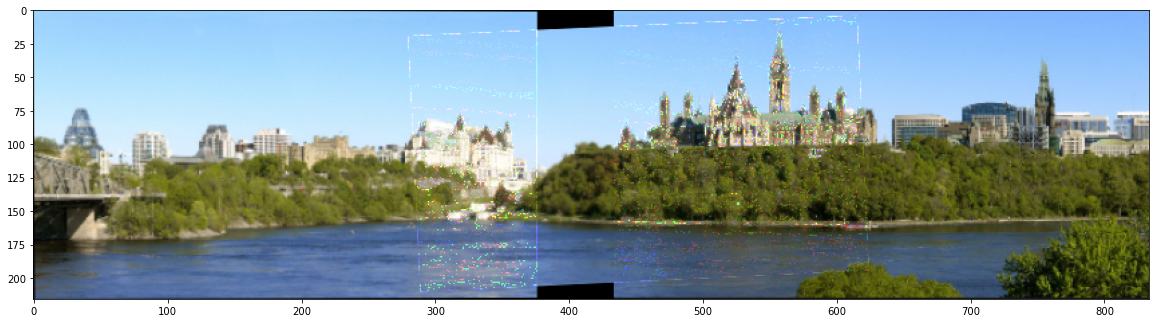

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(third)

# Questão 3

Essa questão foi respondida em um arquivo separado, o qual pode ser acessado em https://github.com/lucasmmassa/VisaoComputacional_PLE/blob/main/lista3/questao3.py.

Nela foi feita a calibração de câmera fazendo uso de um vídeo contendo imagens de um tabuleiro de xadrez, sendo feita a identificação dos vértices do tabuleiro e, em seguida, a correção da distorção da câmera. O resultado da marcação dos vértices do tabuleiro foi salvo em um novo vídeo. Tanto vídeo original quanto o resultante podem ser acessados em https://drive.google.com/drive/folders/1L2i5KI8eml50-ui-hoal6tbuYaurVtfj?usp=sharing.

Além disso, foram salvos alguns exemplos da correção de distorção, os quais se encontram em https://github.com/lucasmmassa/VisaoComputacional_PLE/tree/main/lista3/frames_sem_distorcao. Serão mostrados alguns exemplos abaixo.

### Exemplos obtidos na correção de distorção

In [21]:
correction1 = cv2.imread('./frames_sem_distorcao/3.jpg')
correction2 = cv2.imread('./frames_sem_distorcao/7.jpg')

correction1 = cv2.cvtColor(correction1,cv2.COLOR_BGR2RGB)
correction2 = cv2.cvtColor(correction2,cv2.COLOR_BGR2RGB)

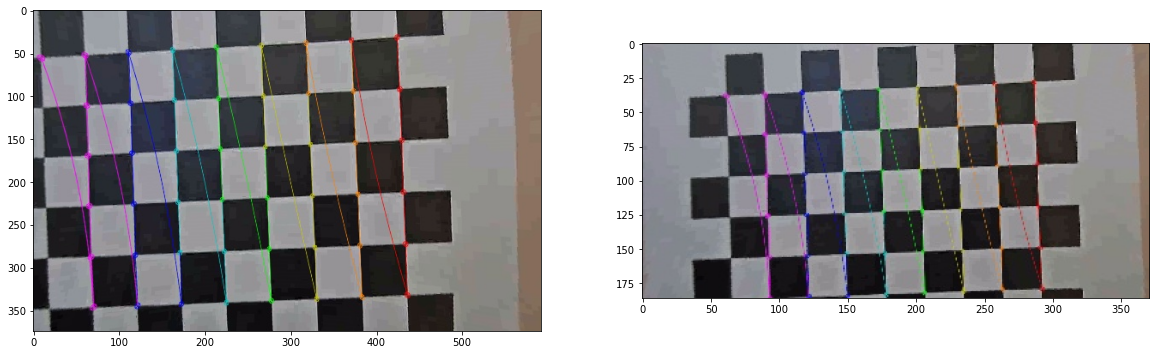

In [23]:
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(correction1)
axarr[1].imshow(correction2)